In [1]:
import sys
sys.path.insert(0,'..')
import simulacra.star
import simulacra.tellurics
import simulacra.detector

from simulacra.star import PhoenixModel

import random
import numpy as np

import astropy.io.fits
import astropy.time as at

import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


<h1>21 - Create a Star with no berv and a linearly increasing rv</h1>
The point of this is to create a dataset that can be used to test the maximal capabilities of fitting within Jabble

In [2]:
class PhoenixStraight(PhoenixModel):
    def generate_spectra(self,detector,obs_times,exp_times):
        # add integral over transmission
        rvs = np.linspace(-6,6,len(obs_times)) * u.km/u.s
        deltas = simulacra.star.shifts(rvs)

        print('surface flux: mean {:3.2e}\t median {:3.2e}'.format(np.mean(self.surface_flux),np.median(self.surface_flux)))
        obs_flux = self.surface_flux * (self.stellar_radius**2/self.distance**2).to(1)
        print('obs     flux: mean {:3.2e}\t median {:3.2e}'.format(np.mean(obs_flux),np.median(obs_flux)))
        # axes.plot(self.wave,obs_flux,'or',alpha=0.3)
        # # axes.set_xlim(6120,6130)
        # plt.show()
        obs_flux = np.outer(np.ones(obs_times.shape),obs_flux)
        # obs_flux = stellar_to_detector_flux(self,detector,exp_times)
        return obs_flux, self.wave, deltas, rvs

In [3]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
det_dict = simulacra.detector.expres_dict
loc = det_dict['loc']
target = coord.SkyCoord(ra,dec,frame='icrs')

Functions from the star module can be used to select times to view a given star from some observatory.

In [4]:
tstart = at.Time('2020-01-01T08:10:00.123456789',format='isot',scale='utc')
tend   = tstart + 180 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend,steps_per_night=5)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [5]:
epoches = 5

Now we selected some random sample of these to observe at and the airmasses at those times

In [6]:
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

<h2>Tellurics Model</h2>
The tellurics model requires these airmasses at the time of observation. However each of the pressure, temperatures, and humidities can be set by the user after initialization. If a single value is passed that is used for every epoch. Or you can pass it an array of quantities of size equal to the number of epoches.

In [7]:
wave_min = 700*u.nm
wave_max = 710*u.nm
tellurics_model = simulacra.tellurics.TelFitModel(wave_min,wave_max,loc)

Define some atmospheric parameters for the tellurics. These can either be constant over all time or an array with the same length as the number of epoches.

In [8]:
tellurics_model.pressure    = np.random.uniform(870,880,epoches) * u.hPa
tellurics_model.humidity    = np.random.uniform(45.0,55.0,epoches)
tellurics_model.temperature = np.random.uniform(300,310,epoches) * u.Kelvin

<h2>Star Model</h2>
Here we define the star model with some temperature, distance, logg, and companion parameters. The logg, T, z, and alpha parameters must correspond to an appropriate atmosphere model from the PHOENIX libraray online. Then also give it some companion parameters that could affect its velocity. This is what we will be trying to find use jabble.

z is metallicity. And distance can be set to whatever you want.

In [9]:
logg = 1.0
T    = 4800
z    = -1.0
alpha= 0.4
distance  = 100 * u.pc
amplitude = 10 * u.m/u.s
period    = 7 * u.day
stellar_model = PhoenixStraight(distance,alpha,z,T,logg,target,amplitude,period)

using saved wave file
../data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in ../data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


<h2>Detector</h2>
Here we define our detector giving it an aperature area, resolution, dark current, read noise, and ccd efficiency. All of these can be except area can be given as an array of the same size as the wave_grid (eg. if the detector has varying resolution or noise levels)

In [10]:
det_dict

{'resolution': 130000.0,
 'area': <Quantity 14.52201204 m2>,
 'dark_current': <Quantity 100. 1 / s>,
 'read_noise': 100,
 'ccd_eff': 0.99,
 'through_put': 0.05,
 'wave_grid': <Quantity [7000.        , 7000.01346154, 7000.0269231 , ..., 9499.95230827,
            9499.97057741, 9499.98884659] Angstrom>,
 'loc': <EarthLocation (-1918329.73705223, -4861253.21396165, 3647910.33904671) m>}

In [11]:
detector = simulacra.detector.Detector(stellar_model,**det_dict)

In [12]:
detector.add_model(tellurics_model)

wave_grid max -> 711.0 nm


In [13]:
exp_times = 8 * np.ones(epoches) * u.min

<h2>Simulator</h2>
Now comes the bulk of the work, run the simulation with the given transmission models, star, detector at the given times for some exposure times.

In [14]:
# if not hasattr(snrs,'__iter__'):
#     print('hi')

In [15]:
snrs = 300
wavelength_trigger = 705 * u.nm
# transmission
data = detector.simulate(obs_times,snrs=snrs,wavelength_trigger=wavelength_trigger)

surface flux: mean 1.31e+14 erg / (cm3 s)	 median 1.14e+14 erg / (cm3 s)
obs     flux: mean 3.78e-02 erg / (cm3 s)	 median 3.28e-02 erg / (cm3 s)
generating spectra...
humidity: 48.70960835383612
 pressure: 872.3831732783954
 temperature: 300.4280790645145
 lat: 35.09666666666667
 elevation: 2.198000000000354
 freqmin(cm-1): 14064.697609001405
 freqmax(cm-1): 14306.151645207437
 angle: 64.4350246802715

72243
humidity: 50.952616812412145
 pressure: 872.4195857495552
 temperature: 308.3325233300081
 lat: 35.09666666666667
 elevation: 2.198000000000354
 freqmin(cm-1): 14064.697609001405
 freqmax(cm-1): 14306.151645207437
 angle: 47.60776619388473

76880
humidity: 52.74680209776581
 pressure: 873.9739376933994
 temperature: 307.72777889050764
 lat: 35.09666666666667
 elevation: 2.198000000000354
 freqmin(cm-1): 14064.697609001405
 freqmax(cm-1): 14306.151645207437
 angle: 69.38313247539092

76880
humidity: 53.8270476448612
 pressure: 871.1249766110839
 temperature: 304.8314824717951
 lat:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


adding noise...
generating exp signal to noise ratios...
generating errors...
done.


In [16]:
(14 * u.m**2 * 0.03 * u.Angstrom * 6300 * u.Angstrom * 8 * u.min * 324 * u.erg/(u.s*u.cm**3) /(const.hbar * const.c)).to(1)

<Quantity 1.30160505e+13>

Save file to pickle jar

In [17]:
outdir = ''
filename = '../out/data_e{}_R{}_a{}_p{}_l{:3.1e}{:3.1e}_snr{:2.1e}'.format(epoches,det_dict['resolution'],\
                                                                amplitude.to(u.m/u.s).value,\
                                                                period.to(u.day).value,\
                                                                detector.lambmin.value,\
                                                                detector.lambmax.value,\
                                                                np.mean(data['data']['snr_readout']))
print(filename)
data.to_pickle(filename + '.pkl')
data.to_h5(filename + '.h5')

../out/data_e5_R130000.0_a10.0_p7.0_l7.0e+037.1e+03_snrnan
saving time
epoches  saving as string
transmission  saving as string
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
flux  saving as string
wave  saving as string
wavetransform  saving as string
quantity
quantity
quantity
alpha  saving as string
quantity
quantity
fluxname  saving as string
generate_spectra  saving as string
get_spectra  saving as string
get_velocity  saving as string
quantity
quantity
logg  saving as string
outdir  saving as string
quantity
plot  saving as string
plot_interpolated  saving as string
quantity
quantity
saving target...4.938387497125083 deg 51.83052204679116 deg
temperature  saving as string
quantity
quantity
wavename  saving as string
quantity
z  saving as string
quantity
quantity
_resolution  saving as string
quantity
a  saving as string
add_model  saving as string
quantity
checkmax  saving as string
checkmin  saving as string
convolve  saving as string
energy_to_photon_po

In [18]:
print(target)

<SkyCoord (ICRS): (ra, dec) in deg
    (4.9383875, 51.83052205)>


In [19]:
import matplotlib.pyplot as plt
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

nan nan
nan nan
nan nan


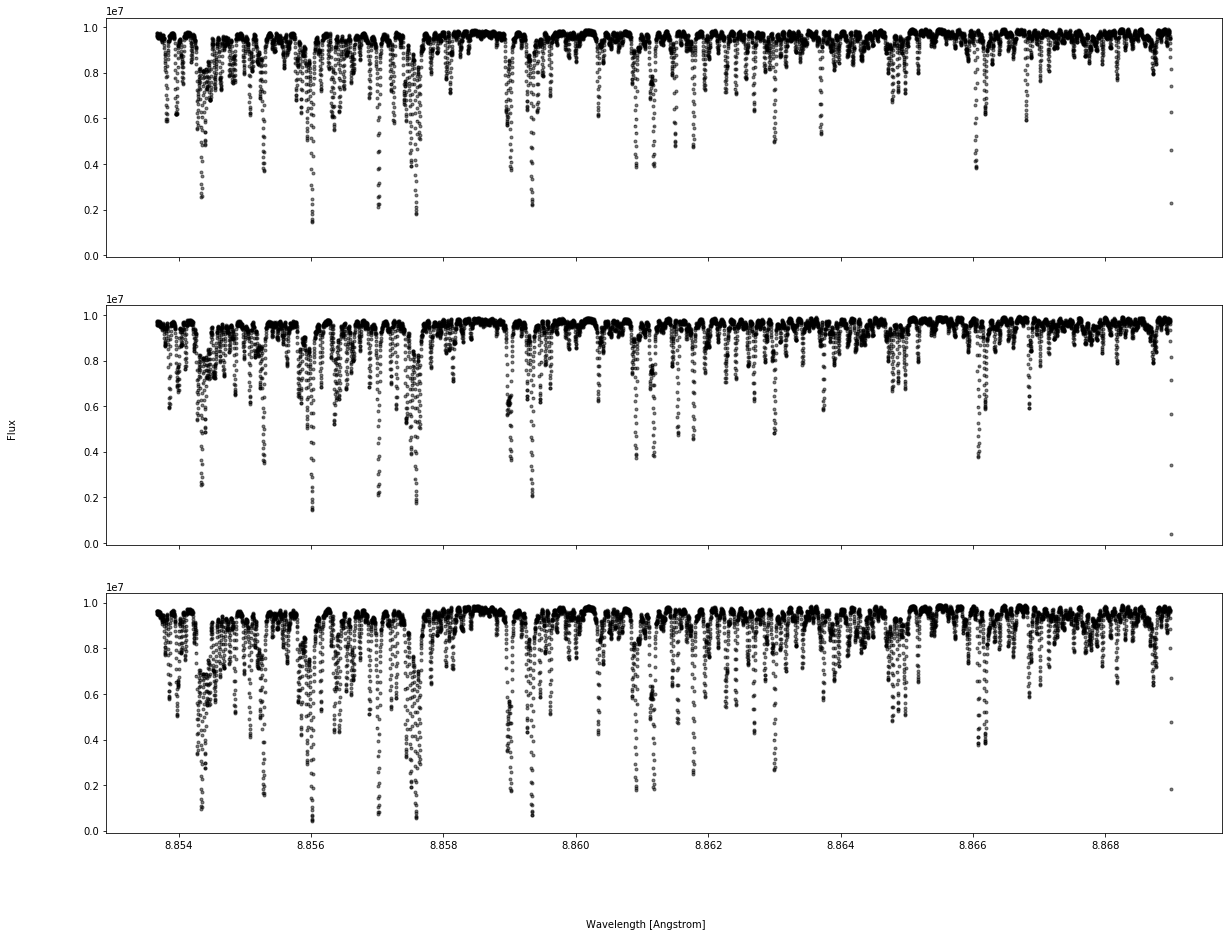

In [20]:
sigma = 200
n_plots = 3
plt_unit = u.Angstrom
sort_times = np.argsort(obs_times)
fig, axes = plt.subplots(n_plots,figsize=(20,5 * n_plots),sharex=True,sharey=True)

fig.text(0.5, 0.04, 'Wavelength [{}]'.format(plt_unit), ha='center', va='center')
fig.text(0.06, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
for i in range(n_plots):
#     axes[i].set_xlim(np.log(6297),np.log(6300))
#     axes[i].set_ylim(-1.2,1.2)
    print('{:3.2e}'.format(np.mean(data['data']['flux'][i,:])),'{:3.2e}'.format(np.mean(data['data']['ferr'][i,:])))
    axes[i].errorbar(np.log(data['data']['wave'].to(u.Angstrom).value),data['data']['flux'][i,:],yerr=data['data']['ferr'][i,:],fmt='.k',alpha=0.5)
#     data.plot_data(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_tellurics(axes[i],sort_times[i],xy='x',units=plt_unit)#,normalize=normalize,nargs=[sigma]
#     data.plot_gas(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_theory(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_lsf(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_star(axes[i],sort_times[i],xy='x',units=plt_unit)
# plt.savefig('out/datatest5.png')
plt.show()

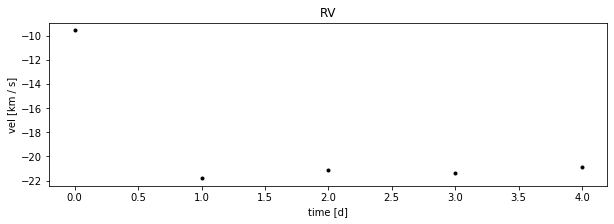

In [21]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
rv = data['data']['rvs'].to(u.km/u.s)

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot(rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

In [22]:
import numpy as np

In [23]:
arr = np.linspace(0,1)
arr = np.repeat(arr,axis=0,repeats=3)

In [24]:
import scipy.optimize

In [25]:
help('scipy.optimize.root')

Help on function root in scipy.optimize:

scipy.optimize.root = root(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)
    Find a root of a vector function.
    
    Parameters
    ----------
    fun : callable
        A vector function to find a root of.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its Jacobian.
    method : str, optional
        Type of solver. Should be one of
    
            - 'hybr'             :ref:`(see here) <optimize.root-hybr>`
            - 'lm'               :ref:`(see here) <optimize.root-lm>`
            - 'broyden1'         :ref:`(see here) <optimize.root-broyden1>`
            - 'broyden2'         :ref:`(see here) <optimize.root-broyden2>`
            - 'anderson'         :ref:`(see here) <optimize.root-anderson>`
            - 'linearmixing'     :ref:`(see here) <optimize.root-linearmixing>`
            - 'diagbroyden'      :ref:`(see her